In [ ]:
import os
import yaml
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plateconfig import PlateConfig


general_data_dir = "../data"
all_dirs = ["07182025_IF_scan"]
config_dict = {}
if_data_file = "Cell.csv"

for data_dir in all_dirs:
	config_fname = f"{general_data_dir}/{data_dir}/plate_config.yaml"
	if os.path.exists(config_fname):
		plate_obj = PlateConfig(config_fname)
		config_dict[data_dir] = plate_obj
	else:
		print(f"Config file does not exist.")


Successfully loaded ../data/07182025_IF_scan/plate_config.yaml


In [ ]:
dfs = []
for dir in all_dirs:
	full_fname = f"{general_data_dir}/{dir}/{if_data_file}"
	columns = ["WellId", "CircTotalIntenCh2", "CircTotalIntenCh3"]
	df = pd.read_csv(full_fname, usecols=columns)
	df["WellId"] = [x.strip() for x in df["WellId"]] # remove leading/trailing spaces in WellIds

	# get the corresponding configuration dictionary
	plate_config = config_dict[dir]
	plate_config.rows = plate_config.row_to_patient.keys()
 
	columns = list(plate_config.column_to_stain.keys())
	# Combine control wells (i.e., B1 and B2) into a single WellId
	if plate_config.double_control_wells:
		control_column_tuples = [(1,2),(7,8)]
		control_well_dict = {}
		for tup in control_column_tuples:
			for row in plate_config.row_to_patient.keys():
				well_id1 = f"{row}{tup[0]:02d}"
				well_id2 = f"{row}{tup[1]:02d}"
				df = df.replace(well_id2, well_id1)
		columns.remove(2)
		columns.remove(8)
	plate_config.control_columns = [1, 7]
	plate_config.test_columns = [np.r_[3:7], np.r_[9:13]]
	plate_config.columns = columns
 
	# store row and columns for each well id as individual columns
	df["Row"] = [x[0] for x in df["WellId"]]
	df["Column"] = [x[1:] for x in df["WellId"]]
	plate_config.set_plate_data(df)
	display(df)

,WellId,CircTotalIntenCh2,CircTotalIntenCh3,Row,Column
0,B01,1928539,644046,B,01
1,B01,1344189,376605,B,01
2,B01,1626749,357199,B,01
3,B01,2920563,953703,B,01
4,B01,2137419,1189482,B,01
...,...,...,...,...,...
58918,E12,662498,180994,E,12
58919,E12,1755947,319289,E,12
58920,E12,2167799,387586,E,12
58921,E12,1840855,279931,E,12


In [ ]:
def find_pct_max(values):
	return np.divide(values, np.max(values))

for dir in all_dirs:
	plate = config_dict[dir]
	data = plate.data
	pct_max_dfs = []
	for row in data["Row"].unique():
		for i, control_col in enumerate(plate.control_columns):
			select_cols = [control_col, *plate.test_columns[i]]
			formatted_select_cols = [f"{x:02d}" for x in select_cols]
			select_data = data[(data["Row"] == row) & (data["Column"].isin(formatted_select_cols))].copy()
			select_data["STAT1"] = find_pct_max(select_data["CircTotalIntenCh2"])
			select_data["STAT3"] = find_pct_max(select_data["CircTotalIntenCh3"])
			pct_max_dfs.append(select_data)
	pct_max_df = pd.concat(pct_max_dfs, ignore_index=True)
	
	stat1_means = pct_max_df.groupby("WellId")["STAT1"].mean()
	stat1_stds = pct_max_df.groupby("WellId")["STAT1"].std()
	stat3_means = pct_max_df.groupby("WellId")["STAT3"].mean()
	stat3_stds = pct_max_df.groupby("WellId")["STAT3"].std()

	stat_df = pd.concat([stat1_means, stat1_stds, stat3_means, stat3_stds], axis=1)
	stat_df.columns = ["STAT1 Mean", "STAT1 STD", "STAT3 Mean", "STAT3 STD"]

	rows = [x.strip()[0] for x in stat_df.index.values]
	cols = [int(x.strip()[1:]) for x in stat_df.index.values]
	stat_df["STAT"] = [plate.column_to_stain[int(x)] for x in cols]
	stat_df["Donor"] = [plate.row_to_patient[x] for x in rows]
	stat_df["IL-6 Concentration"] = ["10 ng/mL" for x in cols]
	stat_df["Time"] = [plate.column_to_t_pts[int(x)] for x in cols]
	stat_df["Replicate"] = [plate.row_to_replicate[x] for x in rows]
	plate_config.stat_df = stat_df
	display(stat_df)

,STAT1 Mean,STAT1 STD,STAT3 Mean,STAT3 STD,STAT,Donor,IL-6 Concentration,Time,Replicate
WellId,,,,,,,,,
B01,0.082093,0.038577,0.036535,0.011551,pSTAT,626,10 ng/mL,0,1
B03,0.173541,0.123304,0.252209,0.167035,pSTAT,626,10 ng/mL,20,1
B04,0.148603,0.080748,0.165864,0.096453,pSTAT,626,10 ng/mL,40,1
B05,0.094381,0.039853,0.072135,0.034644,pSTAT,626,10 ng/mL,60,1
B06,0.087522,0.024013,0.052632,0.016971,pSTAT,626,10 ng/mL,90,1
B07,0.113661,0.057698,0.092382,0.054918,tSTAT,626,10 ng/mL,0,1
B09,0.189627,0.089759,0.197663,0.091810,tSTAT,626,10 ng/mL,20,1
B10,0.240821,0.135205,0.143244,0.077165,tSTAT,626,10 ng/mL,40,1
B11,0.282511,0.179283,0.141978,0.127103,tSTAT,626,10 ng/mL,60,1


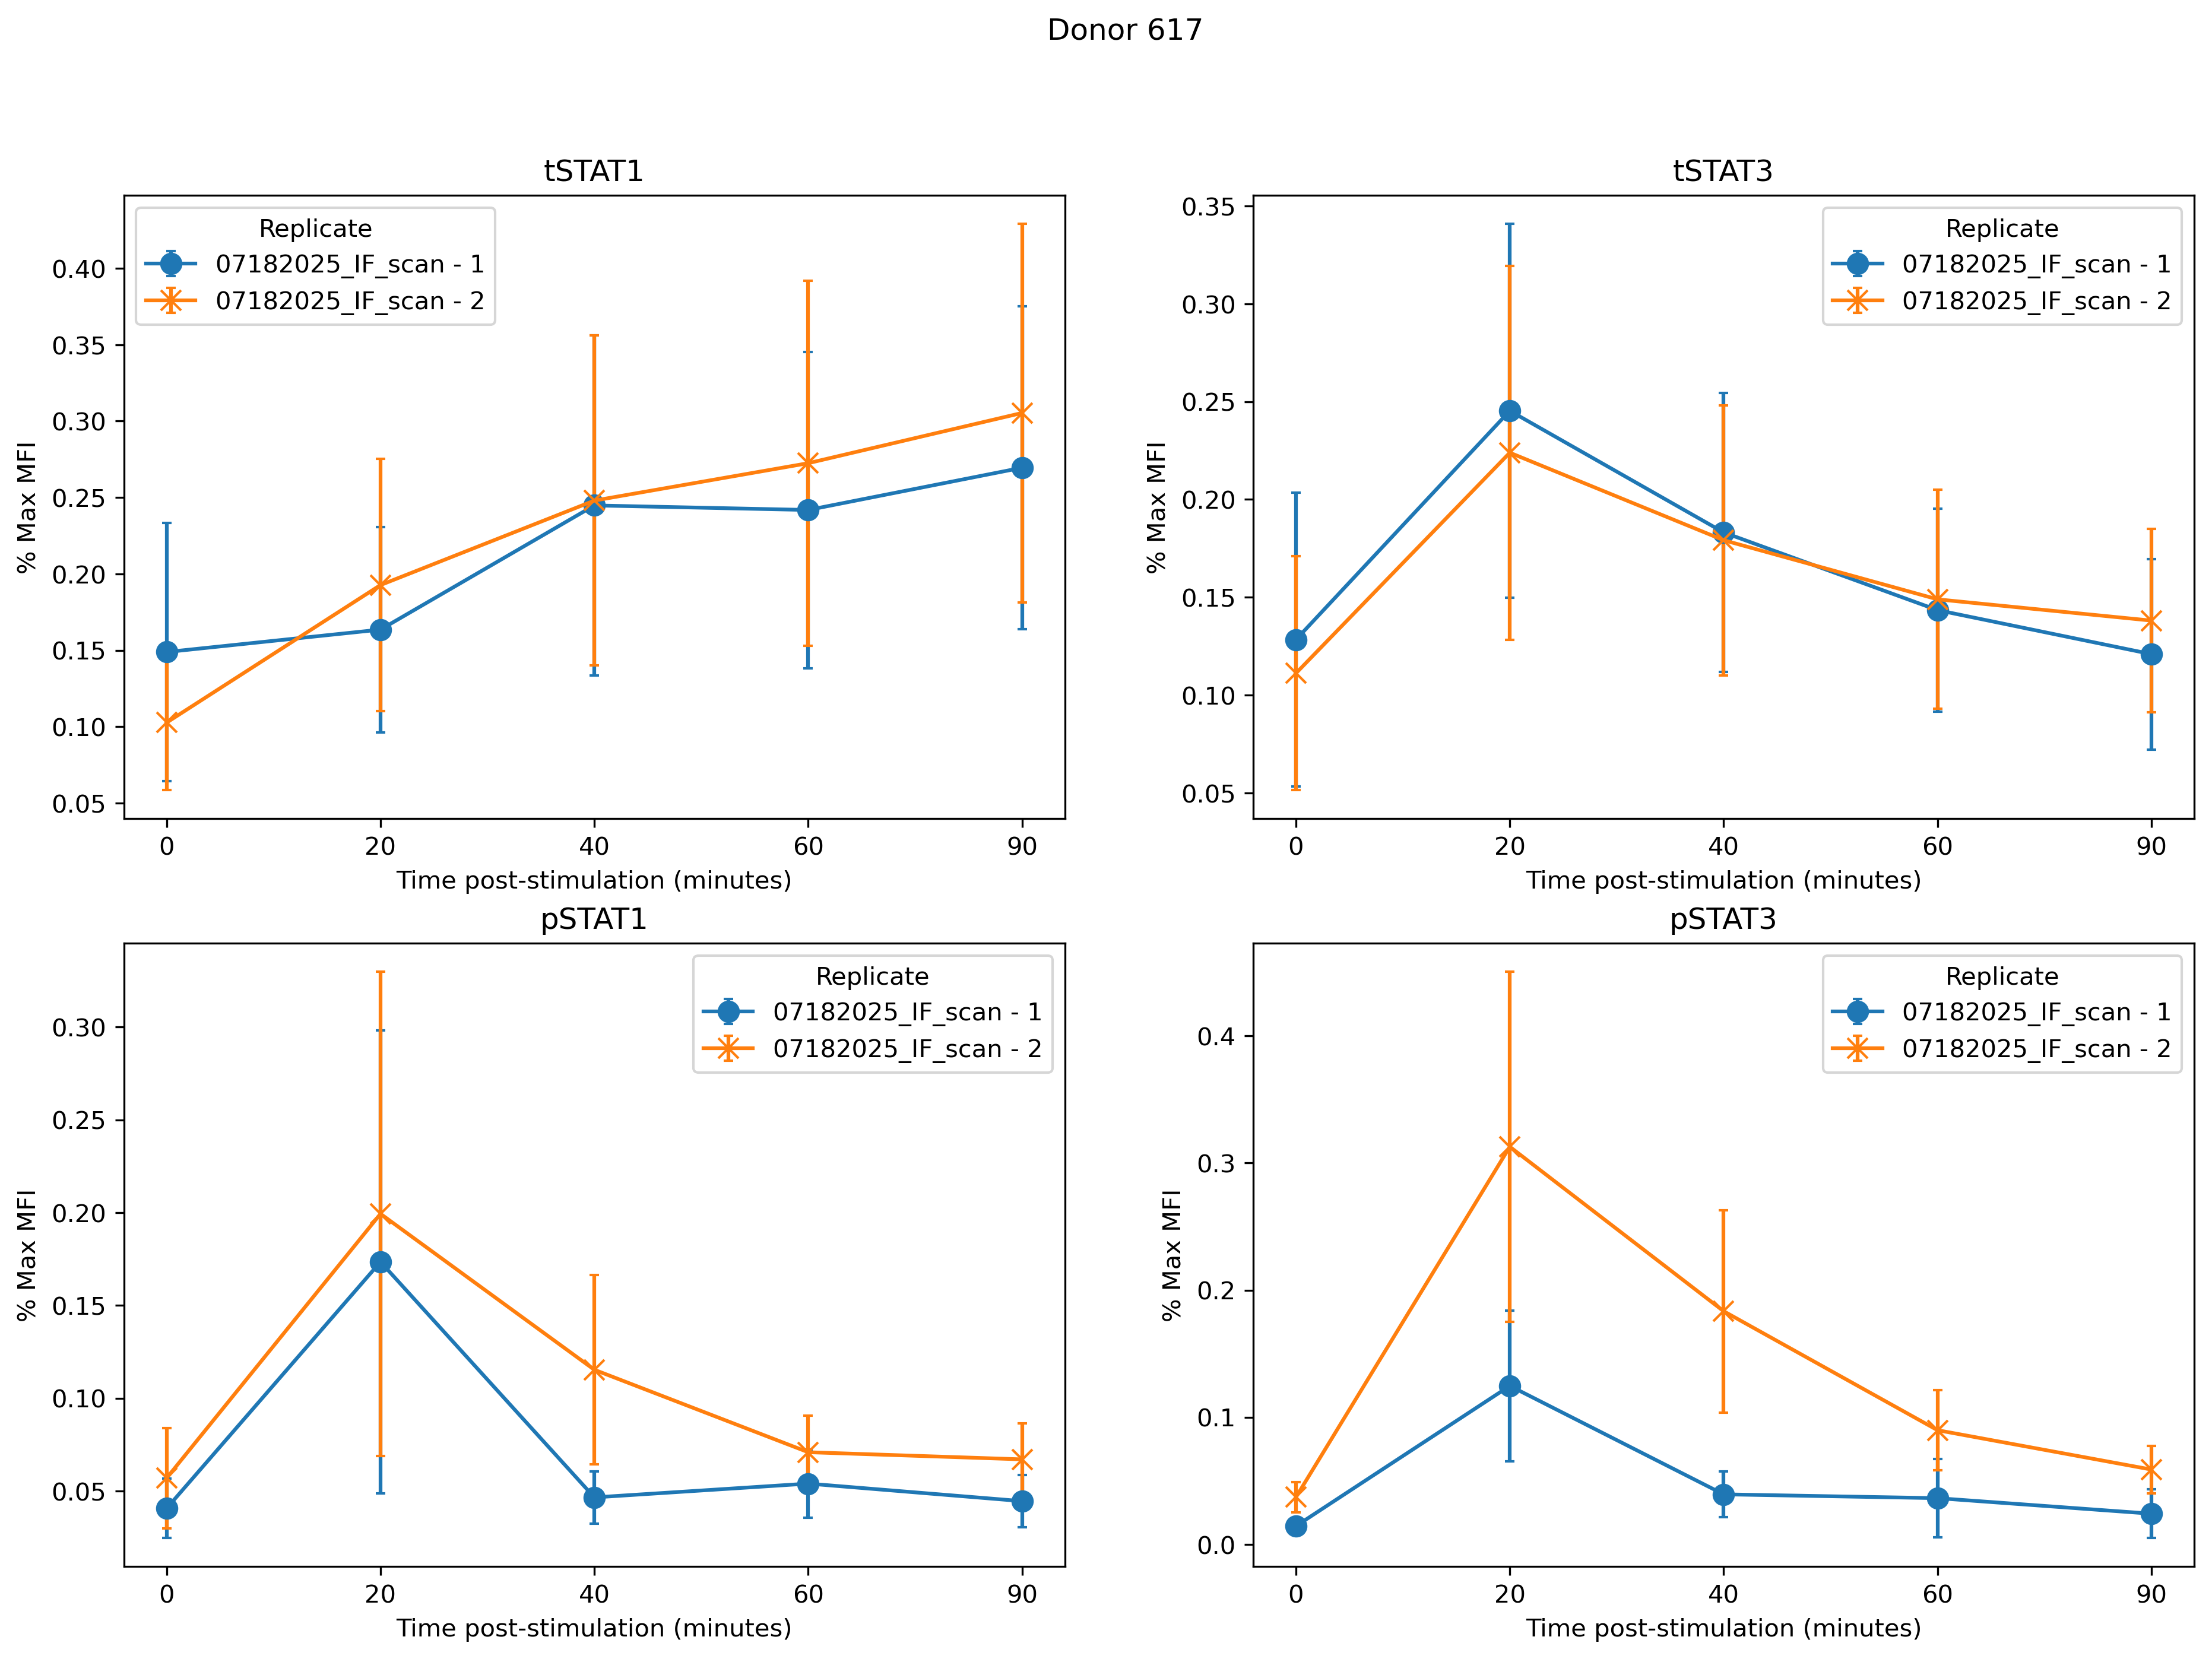

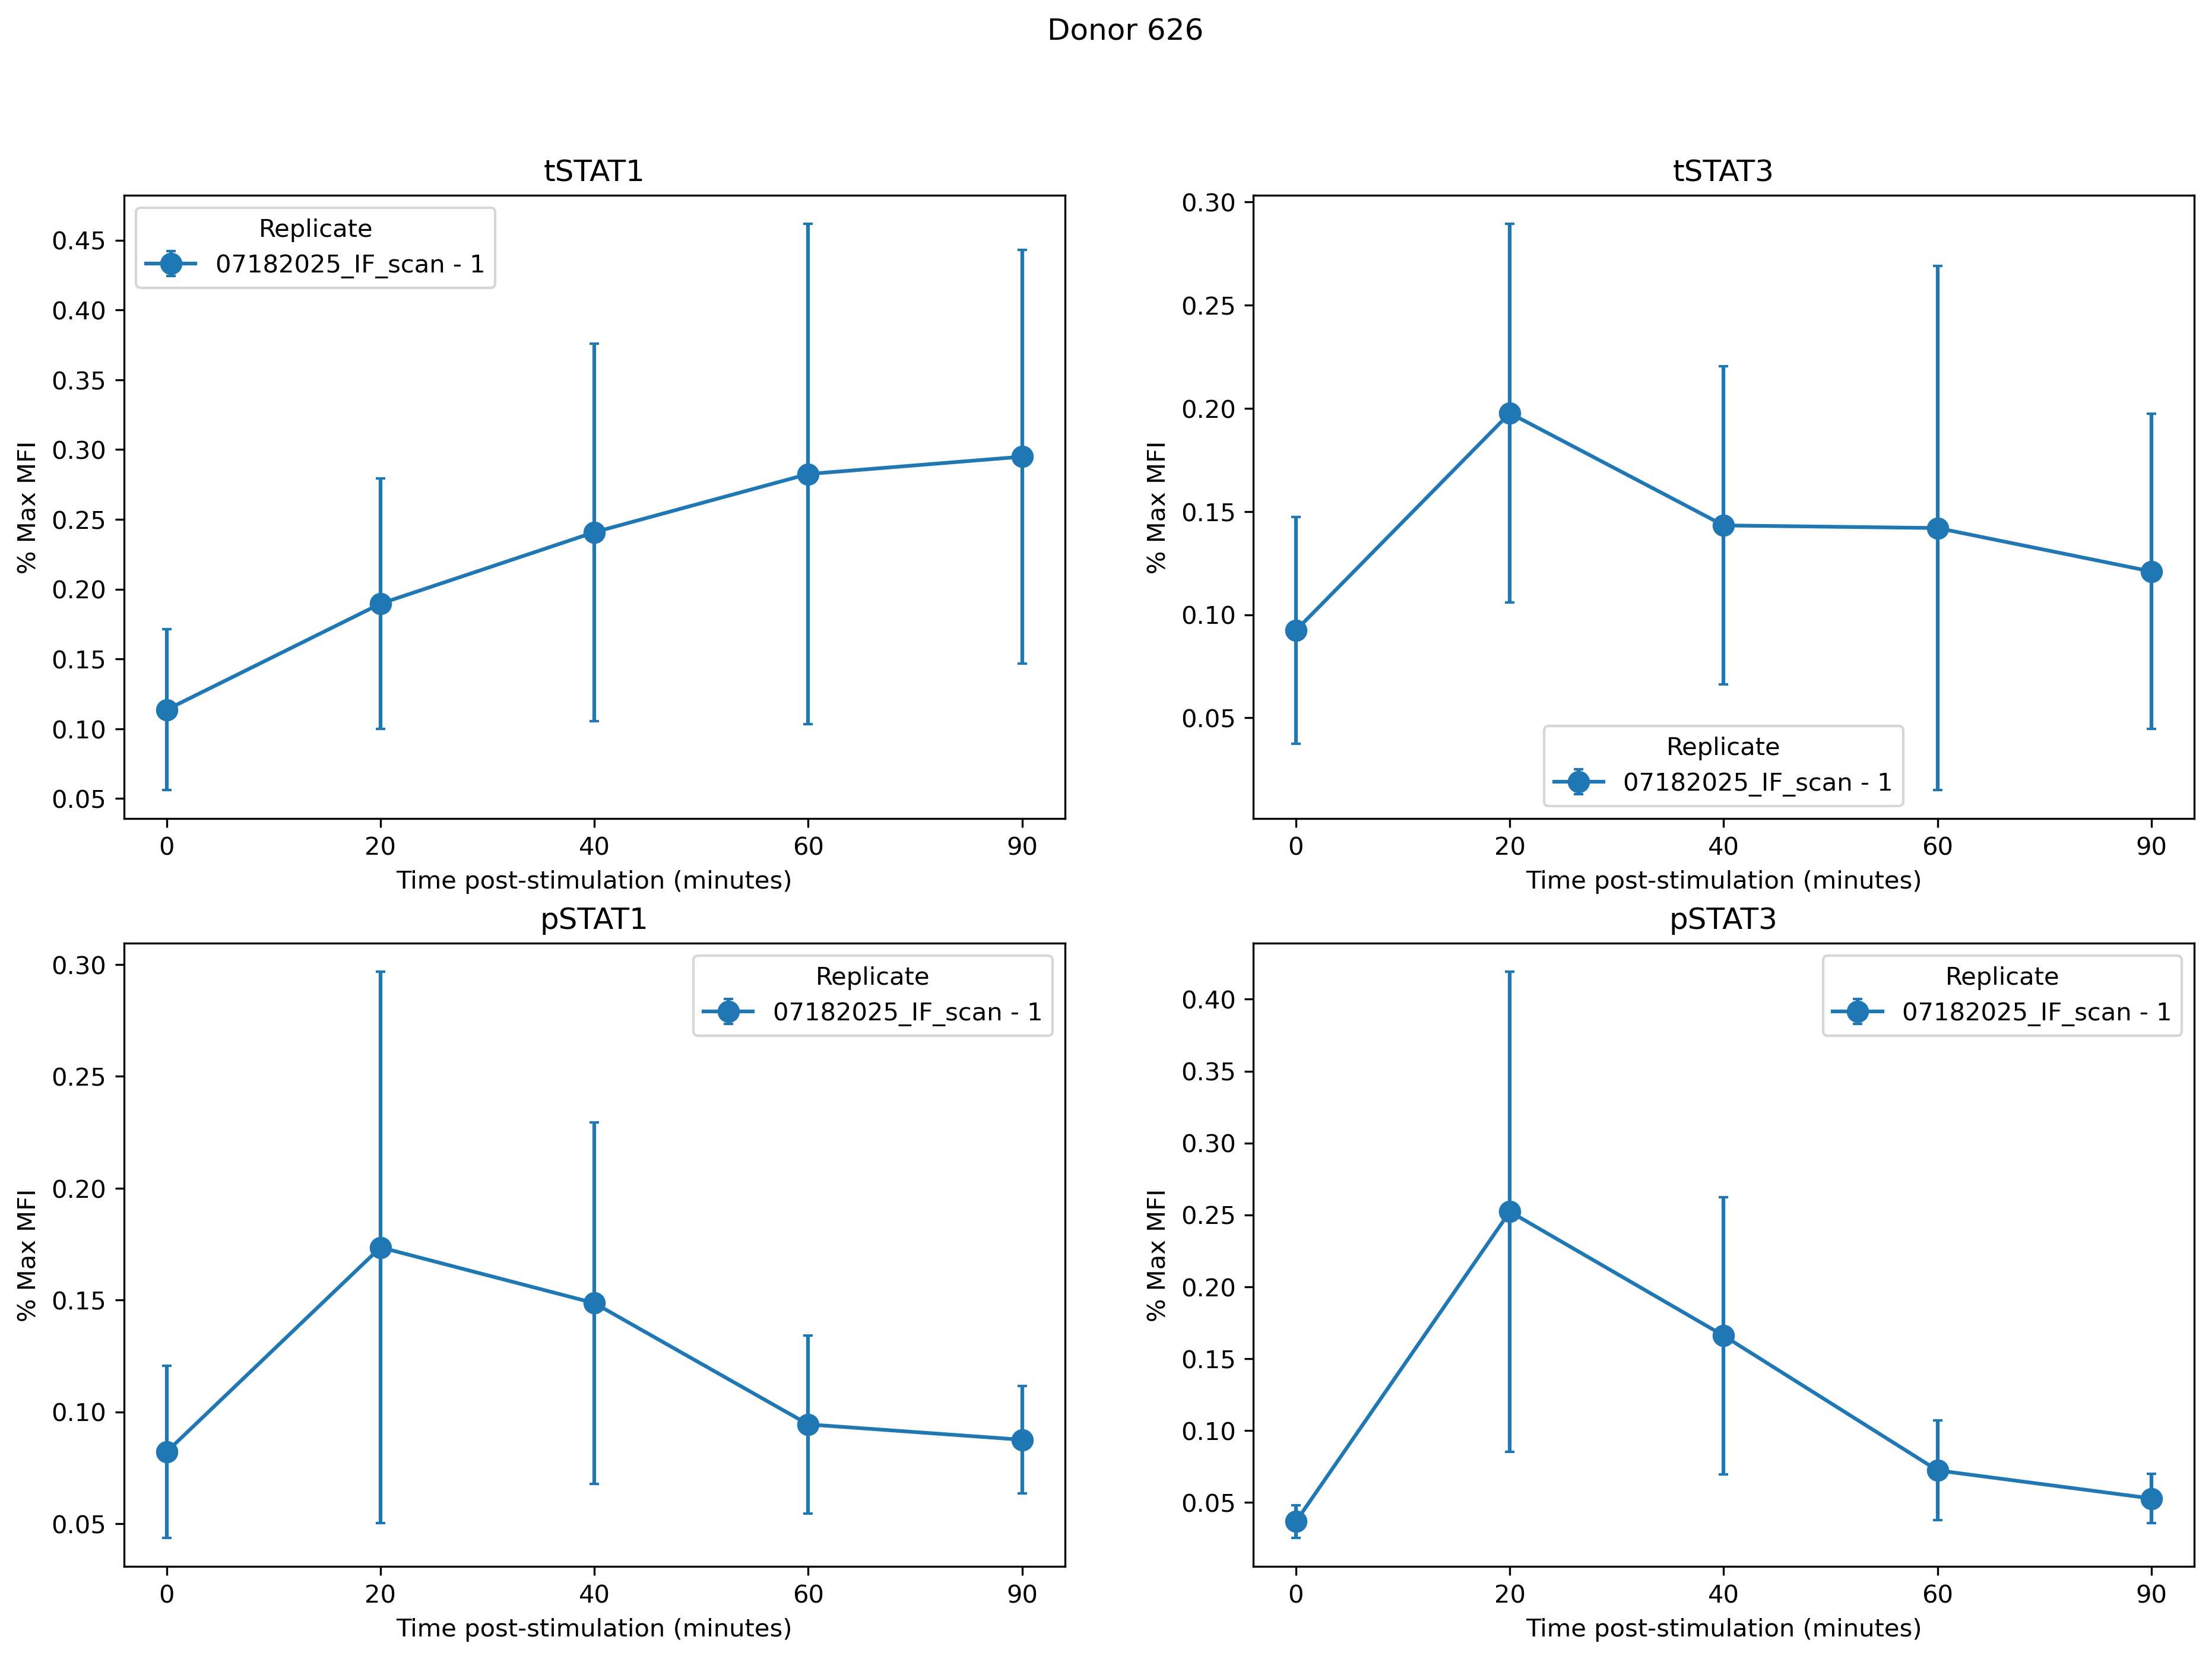

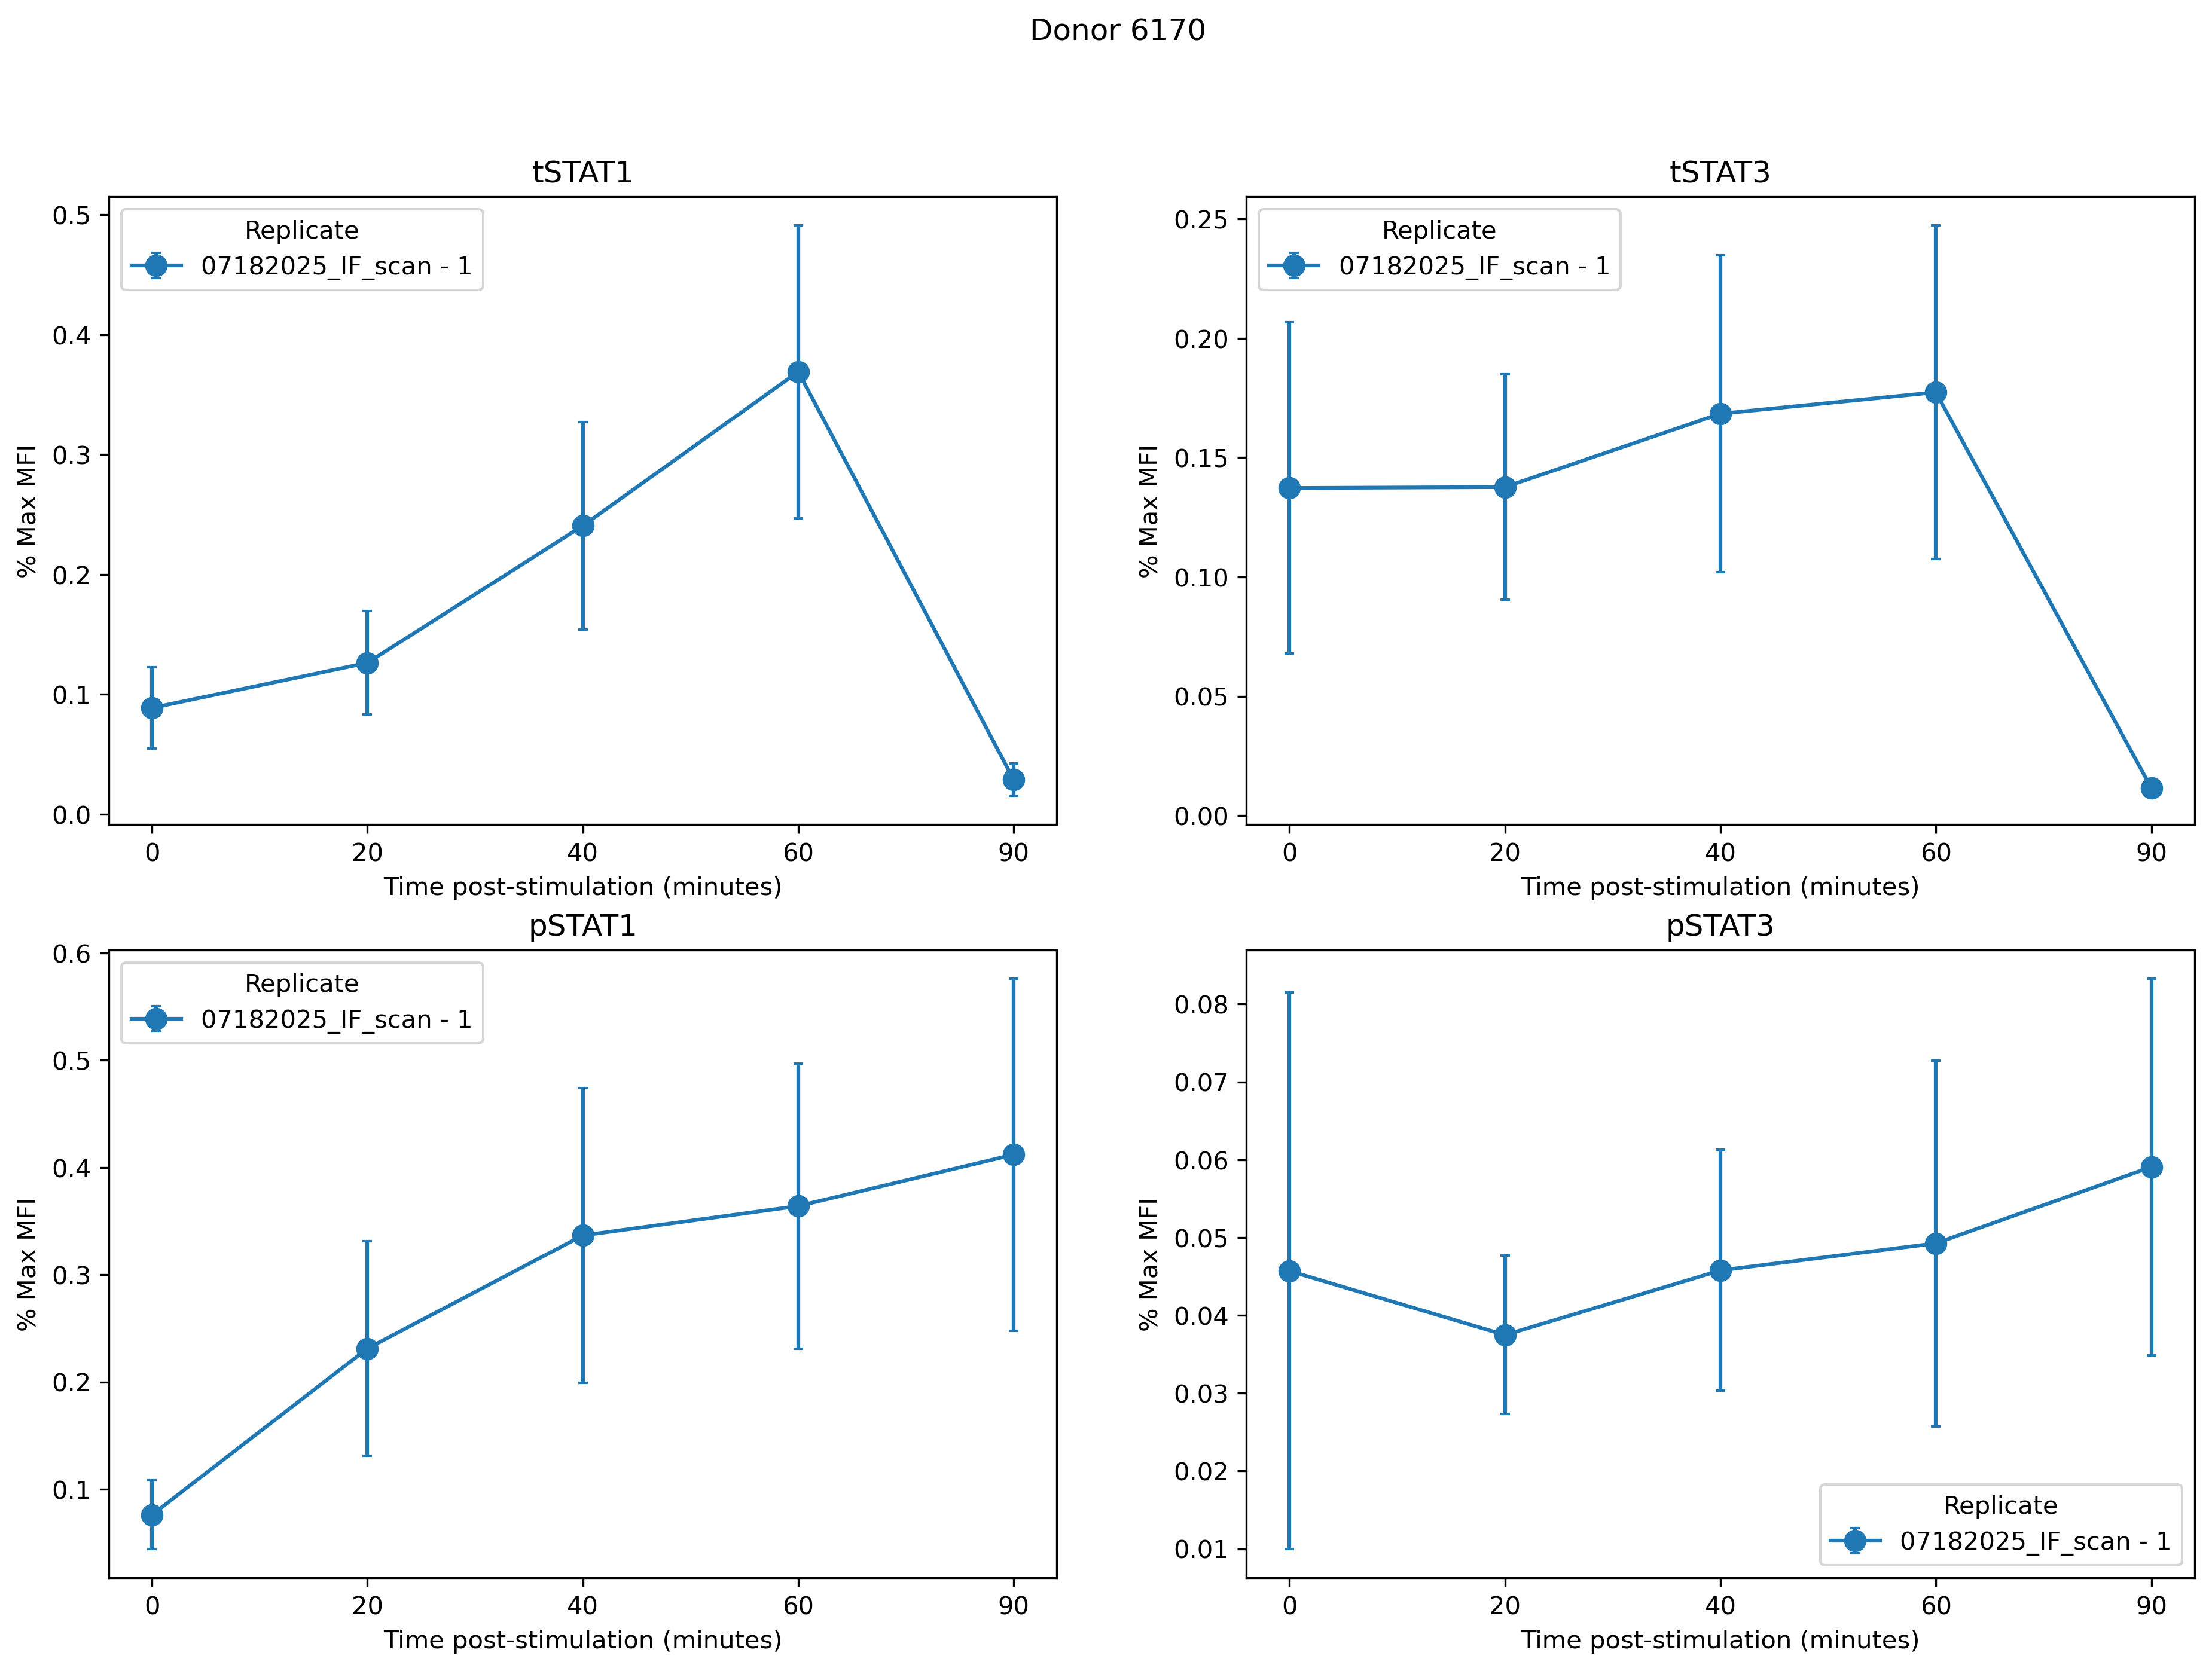

In [24]:
all_ids = np.unique(np.array([config_dict[dir].get_unique_patient_ids() for dir in all_dirs]).flatten())

id_to_fig = dict([id, plt.subplots(2,2, figsize=(15,10), dpi=300)] for id in all_ids);
ms = 8 # markersize

for id in all_ids:
	fig, ax = id_to_fig[id]
	fig.suptitle(f"Donor {id}")
	for dir in all_dirs:
		plate = config_dict[dir]
		
		# Get tSTAT data first 
		df = plate.stat_df[(plate.stat_df["Donor"] == id) & (plate.stat_df["STAT"] == "tSTAT")] # TO DO: add case where included plate does NOT include specific donor
		
		stat1_ax = ax[0][0]
		stat3_ax = ax[0][1]
		for rep in df["Replicate"].unique():
			select_df = df.loc[df["Replicate"]== rep]
			stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
			
			stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
		stat1_ax.set_ylabel("% Max MFI")
		stat1_ax.set_xlabel("Time post-stimulation (minutes)")
		stat1_ax.legend(title="Replicate")
		stat1_ax.set_title("tSTAT1")
		stat3_ax.set_ylabel("% Max MFI")
		stat3_ax.set_xlabel("Time post-stimulation (minutes)")
		stat3_ax.legend(title="Replicate")
		stat3_ax.set_title("tSTAT3")
  
		# Get pSTAT data first 
		df = plate.stat_df[(plate.stat_df["Donor"] == id) & (plate.stat_df["STAT"] == "pSTAT")] # TO DO: add case where included plate does NOT include specific donor
		
		stat1_ax = ax[1][0]
		stat3_ax = ax[1][1]
		for rep in df["Replicate"].unique():
			select_df = df.loc[df["Replicate"]== rep]
			stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
			
			stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
		stat1_ax.set_ylabel("% Max MFI")
		stat1_ax.set_xlabel("Time post-stimulation (minutes)")
		stat1_ax.legend(title="Replicate")
		stat1_ax.set_title("pSTAT1")
		stat3_ax.set_ylabel("% Max MFI")
		stat3_ax.set_xlabel("Time post-stimulation (minutes)")
		stat3_ax.legend(title="Replicate")
		stat3_ax.set_title("pSTAT3")

In [ ]:
from scipy import stats

for dir in all_dirs:
	plate_config = config_dict[dir]
	 
	def pairwise_lfcs(control, test):
		print("IN THE FUNCTION")
		results = []
		for a, b in itertools.product(test, control):
			#print(a,b)
			if b == 0 or a == 0:
				log2fc = np.nan  # avoid division by zero
			else:
				log2fc = np.log2(a / b)
			results.append(log2fc)
		print(results)
		return results

	lfc_df = pd.DataFrame()
	def calculate_fold_changes(plate):
		data = plate.data
		for row in data["Row"].unique():
			for i, control_col in enumerate(plate.control_columns):
				control_well_data = data[(data["Row"] == row) & (data["Column"] == f"{control_col:02d}")]
				
				ctrl_stat1 = control_well_data['CircTotalIntenCh2']
				ctrl_stat3 = control_well_data['CircTotalIntenCh3']
				ctrl_normal_stat, ctrl_pval = stats.shapiro(ctrl_stat1)
				plt.figure()
				plt.title(f"{plate.column_to_stain[control_col]}1 - Row {row} - Donor {plate.row_to_patient[row]}")
				plt.hist(ctrl_stat1, bins=30, label=f"Control ({ctrl_normal_stat:.2f})", alpha=0.5)
				plt.xlabel("Fluorescence Intensity")
				plt.ylabel("Count")
				
				for test_col in plate.test_columns[i]:
					test_data = data[(data["Row"] == row) & (data["Column"] == f"{test_col:02d}")]		
					test_stat1 = test_data['CircTotalIntenCh2']
					test_stat3 = test_data['CircTotalIntenCh3']
		 
					test_normal_stat, test_pval = stats.shapiro(test_stat1)			
					label = f"{plate.column_to_t_pts[test_col]} min ({test_normal_stat:.2f})"
					plt.hist(test_stat1, bins=30, label=label, alpha=0.5)

					#stat1_lfc = pairwise_lfcs(control=control_well_data["CircTotalIntenCh2"],
					#					test=test_data["CircTotalIntenCh2"])
					#stat3_lfc = pairwise_lfcs(control=control_well_data["CircTotalIntenCh3"],
					#					test=test_data["CircTotalIntenCh3"])
					#print("HERE IS STAT! LFCS:", stat1_lfc)
					#break
				plt.legend()
				#break
			#break

	calculate_fold_changes(plate=plate_config)